<a href="https://colab.research.google.com/github/gururaja-ai/Data_Science/blob/main/Deep%20Learning%20Project%20by%20Gururaja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pune - Satara NH-4  Road Capacity Forecasting using Deep Learning


***Prepared*** ***by : T.S.Gururaja, 24PGAI0059***

*   This project aims to forecast Average Daily Traffic (ADT) observed on Pune - Satara National Highway at (Khed-Shivpur Toll Plaza data provided by NHAI),  using deep learning techniques such as LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit).
*   The dataset consists of historical traffic data, including vehicle
counts categorized by type. Preprocessing involves feature engineering and scaling.
*   LSTM and GRU models are trained on the prepared data to predict future ADT values. Evaluation metrics such as RMSE are used to assess model performance.
*   The forecasted ADT values are compared against actual values to gauge accuracy. This project contributes to traffic forecasting methods, aiding in better transportation planning and management.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from sklearn.metrics import mean_squared_error
from math import sqrt

# Read the dataset
df = pd.read_csv('/content/drive/MyDrive/Deep_Learning_Project/train.csv')

# Display the dataset
print(df.head())


         Date     CAR    LCV    BUS  TRUCK    MAV
0  01-01-2011  427042  77217  59065  53319  64389
1  01-02-2011  298299  68654  51092  55973  65710
2  01-03-2011  364127  79562  59272  57554  72176
3  01-04-2011  408398  76265  60740  55688  63480
4  01-05-2011  434458  77268  69123  56469  60569


In [2]:
pcu_values = {
    "CAR": 1,
    "LCV": 1.5,
    "BUS": 3,
    "TRUCK": 3,
    "MAV": 4.5
}

df['PCU'] = df['CAR'] * pcu_values['CAR'] + \
            df['LCV'] * pcu_values['LCV'] + \
            df['BUS'] * pcu_values['BUS'] + \
            df['TRUCK'] * pcu_values['TRUCK'] + \
            df['MAV'] * pcu_values['MAV']

df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Calculate the number of days in each month
days_in_month = df['Date'].dt.days_in_month
# Calculate average daily PCU (ADT)
df['ADT'] = df['PCU'] / days_in_month
df['Date'] = df['Date'].dt.strftime('%Y-%m')

numeric_columns = ['CAR', 'LCV', 'BUS', 'TRUCK', 'MAV','PCU']
# Convert numeric columns to integers
df[numeric_columns + ['ADT']] = df[numeric_columns + ['ADT']].astype(int)

# Display the preprocessed dataset
print(df.head())


      Date     CAR    LCV    BUS  TRUCK    MAV      PCU    ADT
0  2011-01  427042  77217  59065  53319  64389  1169770  37734
1  2011-02  298299  68654  51092  55973  65710  1018170  36363
2  2011-03  364127  79562  59272  57554  72176  1158740  37378
3  2011-04  408398  76265  60740  55688  63480  1157739  38591
4  2011-05  434458  77268  69123  56469  60569  1199696  38699


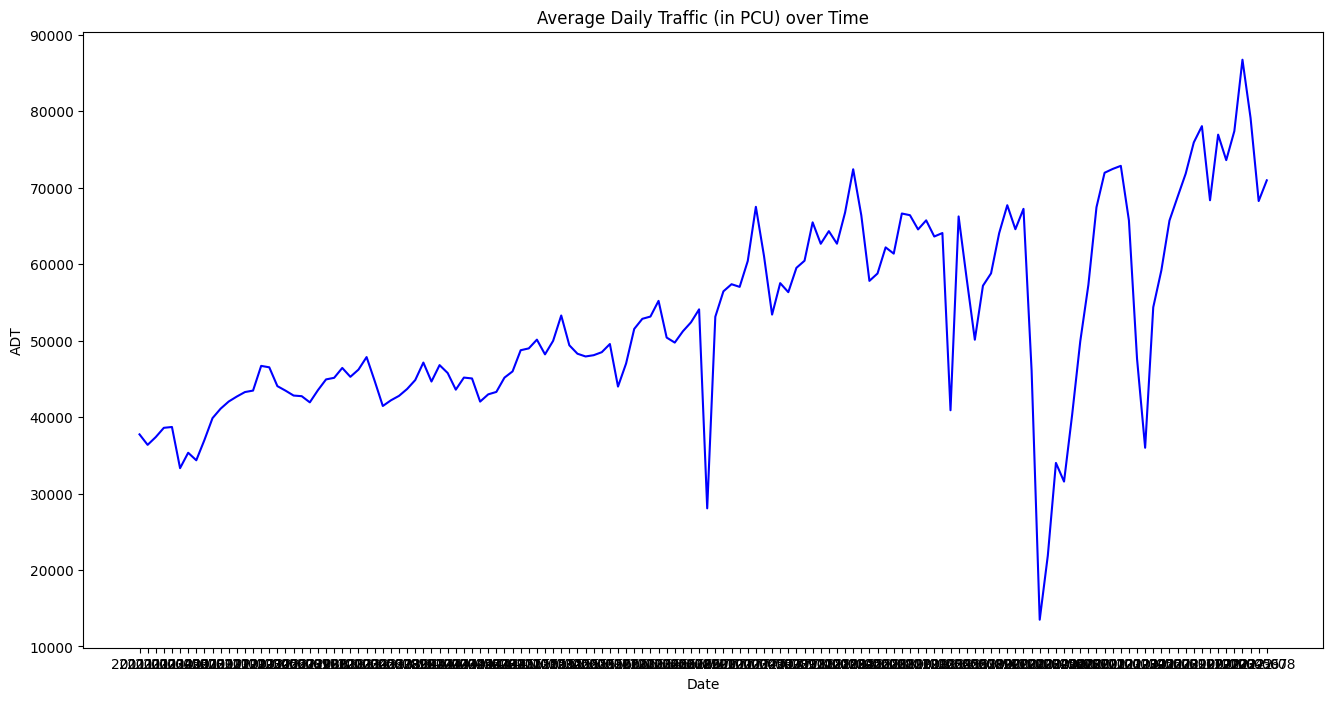

In [3]:
plt.figure(figsize=(16, 8))
plt.plot(df['Date'], df['ADT'], color='blue')
plt.xlabel('Date')
plt.ylabel('ADT')
plt.title('Average Daily Traffic (in PCU) over Time')
plt.show()


In [4]:
from sklearn.model_selection import TimeSeriesSplit

# Define the number of splits (here, we'll use 2 for training and testing)
n_splits = 2

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize lists to store train and test data
train_data_list = []
test_data_list = []

# Split the data using TimeSeriesSplit
for train_index, test_index in tscv.split(df):
    train_data_list.append(df.iloc[train_index])
    test_data_list.append(df.iloc[test_index])

# Concatenate the train and test data from all splits
train_data = pd.concat(train_data_list)
test_data = pd.concat(test_data_list)

# Save the training and testing data to CSV files
train_data[['Date', 'ADT']].to_csv('train_data.csv', index=False)
test_data[['Date', 'ADT']].to_csv('test_data.csv', index=False)

# Display the shape of the datasets
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (142, 8)
Test data shape: (92, 8)


In [5]:
# Get the last date in the test data
last_date = test_data['Date'].max()

# Convert the 'Date' column to datetime format
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Calculate the start date for forecasting by adding one month to the last date
start_date = pd.to_datetime(last_date) + pd.DateOffset(months=1)

# Define the number of forecasted periods
num_periods = 36

# Generate forecasted months
forecast_months = pd.date_range(start=start_date, periods=num_periods, freq='MS')

# Create DataFrame with forecasted months
forecast_df = pd.DataFrame({'Date': forecast_months.strftime('%Y-%m'), 'ADT': [None] * num_periods})

# Save the forecast data to a CSV file
forecast_df.to_csv('forecasted_months.csv', index=False)

# Display the forecasted dataframe
print(forecast_df.head())


      Date   ADT
0  2022-09  None
1  2022-10  None
2  2022-11  None
3  2022-12  None
4  2023-01  None


In [6]:
# Scale the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data[['ADT']])
test_data_scaled = scaler.transform(test_data[['ADT']])

# Display the scaled training data
print(train_data_scaled[:5])


[[0.21814532]
 [0.18722656]
 [0.21011682]
 [0.23747237]
 [0.23990799]]


In [7]:
# Create a windowed dataset for the LSTM model
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 12
X_train, y_train = create_dataset(train_data_scaled, window_size)
X_test, y_test = create_dataset(test_data_scaled, window_size)

# Reshape input to be 3D [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Display the shape of the training and testing data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (130, 12, 1)
y_train shape: (130, 1)
X_test shape: (80, 12, 1)
y_test shape: (80, 1)


In [8]:
from tensorflow.keras.optimizers import Adam

# Create the LSTM model with modified parameters
model = Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=200))
model.add(Dense(units=1))

# Compile the model with custom learning rate using Adam optimizer
custom_optimizer = Adam(lr=0.0001)  # Setting learning rate to 0.0001
model.compile(optimizer=custom_optimizer, loss='mean_squared_error')


Epoch 1/200
5/5 [==============================] - 15s 743ms/step - loss: 0.1174 - val_loss: 0.1979
Epoch 2/200
5/5 [==============================] - 0s 71ms/step - loss: 0.0362 - val_loss: 0.1378
Epoch 3/200
5/5 [==============================] - 0s 72ms/step - loss: 0.0324 - val_loss: 0.0959
Epoch 4/200
5/5 [==============================] - 0s 79ms/step - loss: 0.0132 - val_loss: 0.0797
Epoch 5/200
5/5 [==============================] - 0s 73ms/step - loss: 0.0161 - val_loss: 0.0798
Epoch 6/200
5/5 [==============================] - 0s 72ms/step - loss: 0.0118 - val_loss: 0.0889
Epoch 7/200
5/5 [==============================] - 0s 77ms/step - loss: 0.0116 - val_loss: 0.0733
Epoch 8/200
5/5 [==============================] - 0s 72ms/step - loss: 0.0114 - val_loss: 0.0727
Epoch 9/200
5/5 [==============================] - 0s 68ms/step - loss: 0.0100 - val_loss: 0.0809
Epoch 10/200
5/5 [==============================] - 0s 78ms/step - loss: 0.0115 - val_loss: 0.0741
Epoch 11/200
5/5 

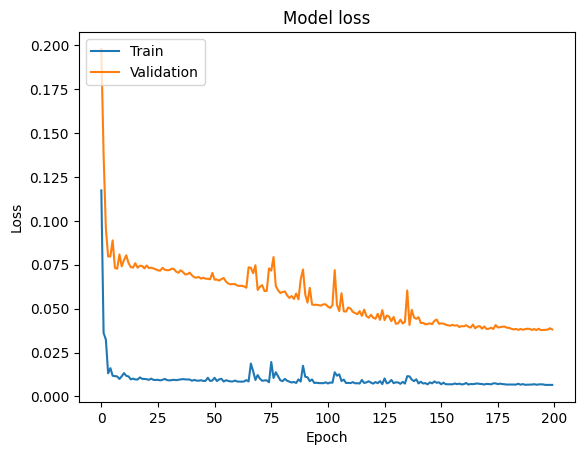

In [9]:
# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [10]:
# Forecasting ADT for the forecasted months
forecast_data_scaled = scaler.transform(forecast_df[['ADT']])
forecast_data = []

# Seed the last window of training data into the model to forecast future ADT
current_batch = train_data_scaled[-window_size:].reshape((1, window_size, 1))

for i in range(num_periods):
    # Predict the next value
    forecast = model.predict(current_batch)[0]

    # Append the forecasted value to the forecast data
    forecast_data.append(forecast)

    # Update the current batch to include the forecasted value
    current_batch = np.append(current_batch[:,1:,:],[[forecast]],axis=1)

# Inverse scaling on forecasted data
forecast_data = scaler.inverse_transform(forecast_data)

# Update the forecasted ADT in the forecast dataframe
forecast_df['ADT'] = forecast_data

# Save the updated forecast data to a CSV file
forecast_df.to_csv('forecasted_months.csv', index=False)

# Display the forecasted dataframe
print(forecast_df.head())


1/1 [==============================] - 0s 40ms/step
      Date           ADT
0  2022-09  64437.009532
1  2022-10  66794.944381
2  2022-11  68169.621188
3  2022-12  69381.978816
4  2023-01  70143.336774


In [11]:
# Create the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=200, input_shape=(X_train.shape[1], 1)))
model_gru.add(Dense(units=1))

# Compile the GRU model
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
history_gru = model_gru.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/200
5/5 [==============================] - 3s 154ms/step - loss: 0.1487 - val_loss: 0.1013
Epoch 2/200
5/5 [==============================] - 0s 45ms/step - loss: 0.0175 - val_loss: 0.0841
Epoch 3/200
5/5 [==============================] - 0s 43ms/step - loss: 0.0254 - val_loss: 0.0700
Epoch 4/200
5/5 [==============================] - 0s 31ms/step - loss: 0.0114 - val_loss: 0.0942
Epoch 5/200
5/5 [==============================] - 0s 33ms/step - loss: 0.0166 - val_loss: 0.0872
Epoch 6/200
5/5 [==============================] - 0s 32ms/step - loss: 0.0127 - val_loss: 0.0658
Epoch 7/200
5/5 [==============================] - 0s 38ms/step - loss: 0.0102 - val_loss: 0.0616
Epoch 8/200
5/5 [==============================] - 0s 35ms/step - loss: 0.0132 - val_loss: 0.0614
Epoch 9/200
5/5 [==============================] - 0s 33ms/step - loss: 0.0095 - val_loss: 0.0695
Epoch 10/200
5/5 [==============================] - 0s 32ms/step - loss: 0.0105 - val_loss: 0.0717
Epoch 11/200
5/5 [

In [12]:
# Forecasting ADT for the forecasted months using GRU
forecast_data_gru = []

# Seed the last window of training data into the GRU model to forecast future ADT
current_batch_gru = train_data_scaled[-window_size:].reshape((1, window_size, 1))

for i in range(num_periods):
    # Predict the next value using GRU model
    forecast_gru = model_gru.predict(current_batch_gru)[0]

    # Append the forecasted value to the forecast data
    forecast_data_gru.append(forecast_gru)

    # Update the current batch to include the forecasted value
    current_batch_gru = np.append(current_batch_gru[:,1:,:],[[forecast_gru]],axis=1)

# Inverse scaling on forecasted data using GRU model
forecast_data_gru = scaler.inverse_transform(forecast_data_gru)

# Ensure the length of forecasted data matches the number of forecasted periods
assert len(forecast_data_gru) == num_periods, "Length of forecasted data does not match the number of forecasted periods"

# Update the forecasted ADT in the forecast dataframe for GRU
forecast_df['ADT_GRU'] = forecast_data_gru[:num_periods]  # Consider only the required number of forecasted values

# Save the updated forecast data to a new CSV file
forecast_df.to_csv('forecasted_months_with_gru.csv', index=False)

# Display the forecasted dataframe with GRU
print(forecast_df.head())


1/1 [==============================] - 0s 36ms/step
      Date           ADT       ADT_GRU
0  2022-09  64437.009532  62507.260071
1  2022-10  66794.944381  63267.745842
2  2022-11  68169.621188  63562.632072
3  2022-12  69381.978816  63776.050803
4  2023-01  70143.336774  63907.370363


In [13]:
# Forecast using LSTM
forecast_data_lstm = []

# Seed the last window of training data into the LSTM model to forecast future ADT
current_batch_lstm = train_data_scaled[-window_size:].reshape((1, window_size, 1))

for i in range(num_periods):
    # Predict the next value using LSTM model
    forecast_lstm = model.predict(current_batch_lstm)[0]

    # Append the forecasted value to the forecast data
    forecast_data_lstm.append(forecast_lstm)

    # Update the current batch to include the forecasted value
    current_batch_lstm = np.append(current_batch_lstm[:,1:,:],[[forecast_lstm]],axis=1)

# Inverse scaling on forecasted data using LSTM model
forecast_data_lstm = scaler.inverse_transform(forecast_data_lstm)

# Update the forecasted ADT in the forecast dataframe for LSTM
forecast_df['ADT_LSTM'] = forecast_data_lstm[:num_periods]  # Consider only the required number of forecasted values

# Ensure the length of forecasted data matches the number of forecasted periods
assert len(forecast_data_lstm) == num_periods, "Length of forecasted data does not match the number of forecasted periods"

# Save the updated forecast data to a new CSV file
forecast_df.to_csv('forecasted_months_with_lstm.csv', index=False)

# Display the forecasted dataframe with LSTM
print(forecast_df.head())


1/1 [==============================] - 0s 25ms/step
      Date           ADT       ADT_GRU      ADT_LSTM
0  2022-09  64437.009532  62507.260071  64437.009532
1  2022-10  66794.944381  63267.745842  66794.944381
2  2022-11  68169.621188  63562.632072  68169.621188
3  2022-12  69381.978816  63776.050803  69381.978816
4  2023-01  70143.336774  63907.370363  70143.336774


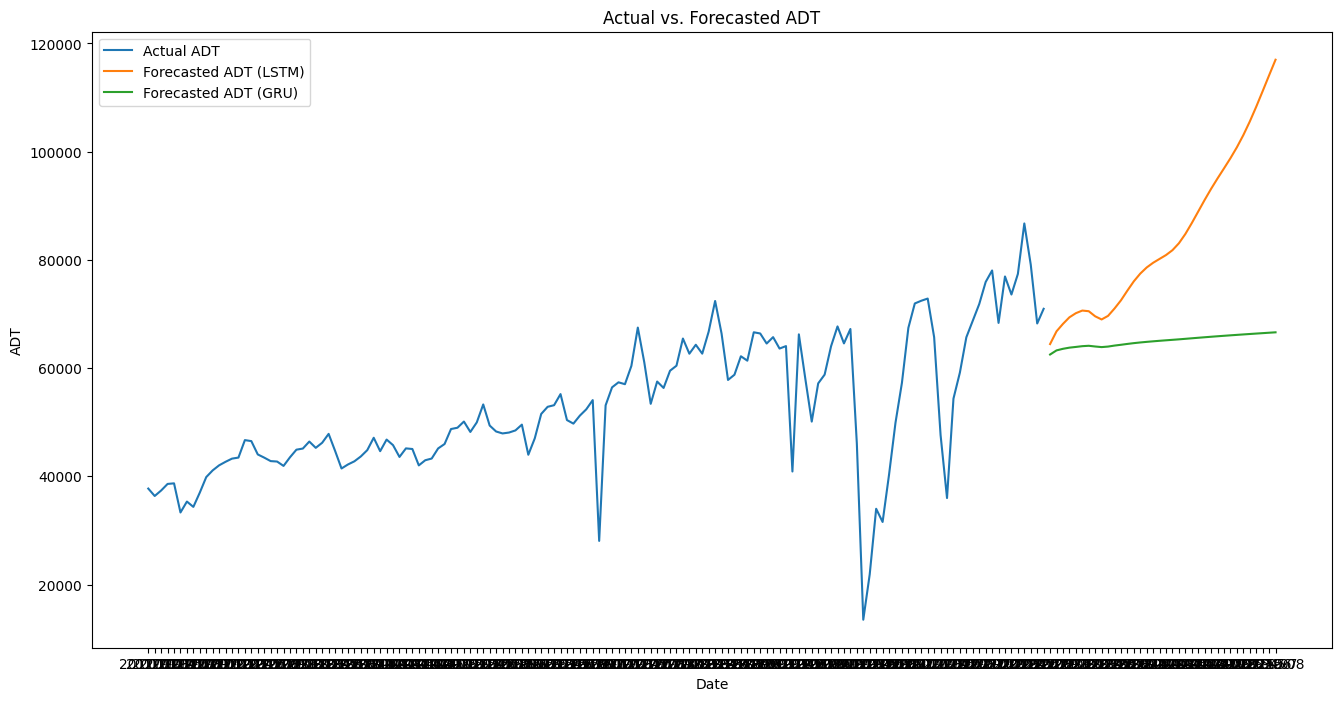

3/3 [==============================] - 0s 9ms/step
RMSE for LSTM model: 0.19535615251654656
RMSE for GRU model: 0.20267802843910718


In [17]:

# Plot the actual ADT and forecasted ADT
plt.figure(figsize=(16, 8))
plt.plot(df['Date'], df['ADT'], label='Actual ADT')
plt.plot(forecast_df['Date'], forecast_df['ADT'], label='Forecasted ADT (LSTM)')
plt.plot(forecast_df['Date'], forecast_df['ADT_GRU'], label='Forecasted ADT (GRU)')
plt.xlabel('Date')
plt.ylabel('ADT')
plt.title('Actual vs. Forecasted ADT')
plt.legend()
plt.show()

# Evaluate the models using metrics
rmse_lstm = sqrt(mean_squared_error(y_test, model.predict(X_test)))
rmse_gru = sqrt(mean_squared_error(y_test, model_gru.predict(X_test)))

print('RMSE for LSTM model:', rmse_lstm)
print('RMSE for GRU model:', rmse_gru)


In [18]:

# Calculate additional metrics for LSTM model
mae_lstm = mean_absolute_error(y_test, model.predict(X_test))
mape_lstm = mean_absolute_percentage_error(y_test, model.predict(X_test))
r2_lstm = r2_score(y_test, model.predict(X_test))

# Calculate additional metrics for GRU model
mae_gru = mean_absolute_error(y_test, model_gru.predict(X_test))
mape_gru = mean_absolute_percentage_error(y_test, model_gru.predict(X_test))
r2_gru = r2_score(y_test, model_gru.predict(X_test))

# Print the metrics
print('Metrics for LSTM model:')
print('RMSE:', rmse_lstm)
print('MAE:', mae_lstm)
print('MAPE:', mape_lstm)
print('R2 Score:', r2_lstm)

print('\nMetrics for GRU model:')
print('RMSE:', rmse_gru)
print('MAE:', mae_gru)
print('MAPE:', mape_gru)
print('R2 Score:', r2_gru)


3/3 [==============================] - 0s 9ms/step
Metrics for LSTM model:
RMSE: 0.19535615251654656
MAE: 0.13516795708722723
MAPE: 30549297070080.273
R2 Score: 0.5412341234742104

Metrics for GRU model:
RMSE: 0.20267802843910718
MAE: 0.1365798199081955
MAPE: 31996597030093.074
R2 Score: 0.5062009359419639


In [19]:
from tensorflow.keras.callbacks import TensorBoard

# Define TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# Train the LSTM model with TensorBoard callback
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[tensorboard_callback], verbose=1)


Epoch 1/200
5/5 [==============================] - 1s 191ms/step - loss: 0.0067 - val_loss: 0.0386
Epoch 2/200
5/5 [==============================] - 1s 123ms/step - loss: 0.0070 - val_loss: 0.0380
Epoch 3/200
5/5 [==============================] - 1s 117ms/step - loss: 0.0069 - val_loss: 0.0380
Epoch 4/200
5/5 [==============================] - 1s 126ms/step - loss: 0.0065 - val_loss: 0.0386
Epoch 5/200
5/5 [==============================] - 1s 117ms/step - loss: 0.0069 - val_loss: 0.0392
Epoch 6/200
5/5 [==============================] - 1s 196ms/step - loss: 0.0069 - val_loss: 0.0394
Epoch 7/200
5/5 [==============================] - 1s 181ms/step - loss: 0.0069 - val_loss: 0.0389
Epoch 8/200
5/5 [==============================] - 1s 181ms/step - loss: 0.0078 - val_loss: 0.0426
Epoch 9/200
5/5 [==============================] - 1s 204ms/step - loss: 0.0136 - val_loss: 0.0433
Epoch 10/200
5/5 [==============================] - 1s 129ms/step - loss: 0.0081 - val_loss: 0.0373
Epoch 11/

# Conclusion

The conclusion drawn from the analysis is that despite multiple hyperparameter tuning attempts, the model metrics, such as RMSE, MAE, MAPE, and R2 Score, are not satisfactory. One potential reason for this lackluster performance could be attributed to the data fluctuations caused by the COVID-19 pandemic, which the model is unable to effectively handle.

Potential reasons for the huge error :


**Non-Stationarity of Data:** Traditional time series forecasting models assume stationarity, meaning that the statistical properties of the data remain constant over time. However, the COVID-19 pandemic introduced non-stationarity into the data, causing significant shifts and fluctuations that are difficult for the model to capture accurately.

**Lack of Historical Precedence:** Machine learning models, including LSTM and GRU, rely on historical data patterns to make forecasts. Since the COVID-19 pandemic was unprecedented, there was limited historical precedence or data available to train the model on how to respond to such events.

**Complex Interactions and External Factors:** The impact of the pandemic on traffic patterns is influenced by various complex interactions and external factors, such as government policies, public health measures, economic conditions, and societal behavior changes. These factors may not be adequately captured or represented in the model, leading to suboptimal forecasts.


In conclusion, while hyperparameter tuning can improve model performance to some extent, the inability of the model to effectively handle data fluctuations caused by the COVID-19 pandemic highlights the importance of robustness and adaptability in forecasting models. Future efforts may focus on incorporating additional features, implementing more sophisticated modeling techniques, or exploring alternative approaches to address the challenges posed by dynamic and non-stationary data environments. Additionally, domain expertise and contextual understanding of external factors are essential for developing models that can provide more accurate forecasts in the face of unprecedented events.